<a href="https://colab.research.google.com/github/djvaroli/samsung_oct/blob/daniel-notebooks/OCT_project_daniel_varoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/djvaroli/samsung_oct.git samsung_oct

Cloning into 'samsung_oct'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 24), reused 53 (delta 15), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [2]:
!pip install -r samsung_oct/requirements.txt
!pip install -e samsung_oct/utilities/

     |████████████████████████████████| 184kB 7.9MB/s 
     |████████████████████████████████| 112kB 62.2MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 1.0MB 46.1MB/s 
     |████████████████████████████████| 286kB 55.3MB/s 
     |████████████████████████████████| 512kB 46.3MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 133kB 43.0MB/s 
     |████████████████████████████████| 6.0MB 44.8MB/s 
     |████████████████████████████████| 4.9MB 52.5MB/s 
     |████████████████████████████████| 153kB 71.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: google-cloud-bigquery 1.21.0 has requirement google-resumable-media!=0.4.0,<0.5.0dev,>=0.3.1, but you'll have google-resumable-media 1.2.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompati

Obtaining file:///content/samsung_oct/utilities
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp37-cp37m-linux_x86_64.whl size=29068 sha256=d615f357c78e509ac4f3955e59f63340c87bc8bdc286dbd8ff9f3dd022d95269
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
Successfully built ciso8601
  Running setup.py develop for utilities


In [4]:
!gsutil -m cp gs://fourth-brain-course-files/capstone-project/data/processed_data.zip .

Copying gs://fourth-brain-course-files/capstone-project/data/processed_data.zip...
Resuming download for ./processed_data.zip component 0
Resuming download for ./processed_data.zip component 1
Resuming download for ./processed_data.zip component 2
Resuming download for ./processed_data.zip component 3
- [1/1 files][  5.4 GiB/  5.4 GiB] 100% Done  48.9 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.4 GiB.                                      


In [5]:
!unzip -q processed_data.zip

# Pre-Requisites

In [6]:
import json

import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from samsung_oct.utilities.callbacks import MachineLearningExperimentTracking

sns.set()

In [8]:
with open("processed_data/formatted_data.json", "r+") as f:
  class_to_label = json.load(f)

### Creating Data Generators

We cannot read the data into memory, hence we will use the tensorflow's image data generator to supply the data batch by batch, rather than all at once.

In [9]:
kwargs = dict(
    preprocessing_function=lambda x: x / 255.
)

In [10]:
generator = ImageDataGenerator(**kwargs)

In [13]:
train_flow = generator.flow_from_directory("processed_data/data/train")
val_flow = generator.flow_from_directory("processed_data/data/val")

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


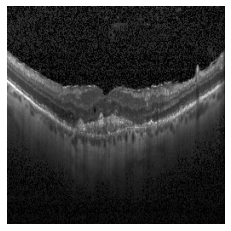

In [14]:
# plot a sample image
# the image will be slightly distorted since we are using the ImageDataGenerator
img_batch, labels_batch = next(train_flow)
img = img_batch[0]
plt.imshow(img)
plt.axis("off")
train_flow.reset()

In [15]:
input_shape = img.shape
print(f"Input shape is {input_shape}")

Input shape is (256, 256, 3)


# DenseNet121

In [18]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False, 
    pooling='max', 
    input_shape=input_shape
)

x = base_model.output
x = Dropout(0.4)(x)

output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output, name="DenseNet121-vanilla")
# Train top layer
for layer in base_model.layers[:-2]:
    layer.trainable = False

print(model.summary())

Model: "DenseNet121-vanilla"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________

In [20]:
experiment_description = "First run of the DenseNet121 on the entire training dataset."
mlet = MachineLearningExperimentTracking(
    "DenseNet121-full-run", 'val_accuracy', experiment_description=experiment_description
    )
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
model.fit(train_flow, epochs=20, callbacks=[mlet], validation_data=val_flow)

Epoch 1/20
2609/2609 [==============================] - 323s 116ms/step - loss: 1.4524 - accuracy: 0.6464 - val_loss: 0.4515 - val_accuracy: 0.8125
Epoch 2/20
2609/2609 [==============================] - 291s 111ms/step - loss: 0.7313 - accuracy: 0.7404 - val_loss: 0.4874 - val_accuracy: 0.7812
Epoch 3/20
2609/2609 [==============================] - 293s 112ms/step - loss: 0.7366 - accuracy: 0.7378 - val_loss: 0.5575 - val_accuracy: 0.7812
Epoch 4/20
2609/2609 [==============================] - 296s 113ms/step - loss: 0.7326 - accuracy: 0.7401 - val_loss: 0.7998 - val_accuracy: 0.6250
Epoch 5/20
2609/2609 [==============================] - 297s 114ms/step - loss: 0.7384 - accuracy: 0.7404 - val_loss: 0.8037 - val_accuracy: 0.7500
Epoch 6/20
2609/2609 [==============================] - 299s 114ms/step - loss: 0.7223 - accuracy: 0.7434 - val_loss: 0.3535 - val_accuracy: 0.8125
Epoch 7/20
2609/2609 [==============================] - 296s 114ms/step - loss: 0.7377 - accuracy: 0.7400 - val_

In [22]:
!gsutil -m cp -r DenseNet121_may-15-2021_9062/ gs://fourth-brain-course-files/capstone-project/experiments/

Copying file://DenseNet121_may-15-2021_9062/DenseNet121-vanilla_weights.h5 [Content-Type=application/octet-stream]...
Copying file://DenseNet121_may-15-2021_9062/DenseNet121-vanilla_training-doc.json [Content-Type=application/json]...
Copying file://DenseNet121_may-15-2021_9062/DenseNet121-vanilla_graph.png [Content-Type=image/png]...
Copying file://DenseNet121_may-15-2021_9062/DenseNet121-vanilla_config.json [Content-Type=application/json]...
/ [4/4 files][ 31.0 MiB/ 31.0 MiB] 100% Done                                    
Operation completed over 4 objects/31.0 MiB.                                     
